# Multivariate Analysis

In [10]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [165]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\df_nadal_clean.csv',sep=',')

In [166]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [167]:
X, y = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_395_FR','AU_395_FL','AT_X','AT_Z']], df[['L/V_FR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

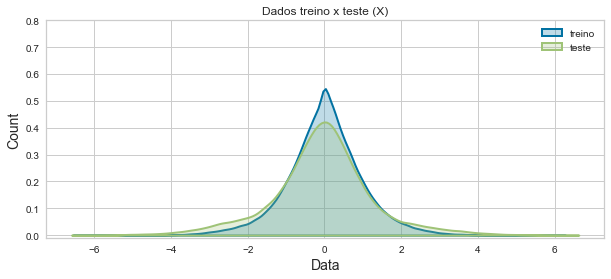

In [169]:
plt.figure(figsize=(10,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])
plt.legend(loc='upper right')

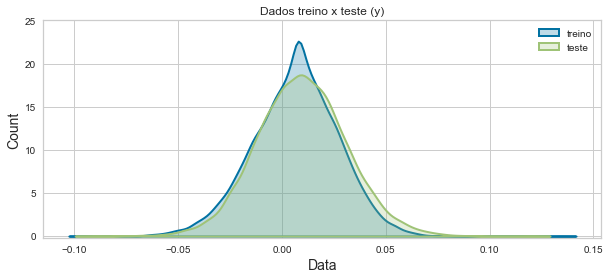

In [170]:
plt.figure(figsize=(10,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (y)")
plt.ylim([-0.2,25])
plt.legend(loc='upper right')

A distribuição parece ser representativa, podemos seguir em frente

In [171]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(random_state=0)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(random_state=0)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = AdaBoostRegressor(random_state=0)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = AdaBoostRegressor()
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('AdaBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(alpha=0.001, l1_ratio=0.2)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(alpha=0.001, l1_ratio=0.2)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(random_state=0, n_jobs=-1)
        mod3 = AdaBoostRegressor(random_state=0)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(alpha=0.001, l1_ratio=0.2)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'AdaBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(n_jobs=-1, random_state=0), AdaBoostRegressor(random_state=0), GradientBoostingRegressor(random_state=0), ExtraTreesRegressor(n_jobs=-1, random_state=0), ElasticNet(alpha=0.001, l1_ratio=0.2)]

Obtaining R2 score for all 6 models


  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_15680\2041063366.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 33%|███▎      | 2/6 [00:26<00:53, 13.35s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 50%|█████     | 3/6 [00:34<00:33, 11.24s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [00:55<00:29, 14.71s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_15680\2041063366.py:150: DataConversionWarning:

A column-vector 

R2 score calculated
Obtaining feature importance - 0%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but AdaBoostRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



Obtaining feature importance - 50%
Obtaining feature importance - 100%
CPU times: total: 1min 54s
Wall time: 1min 7s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

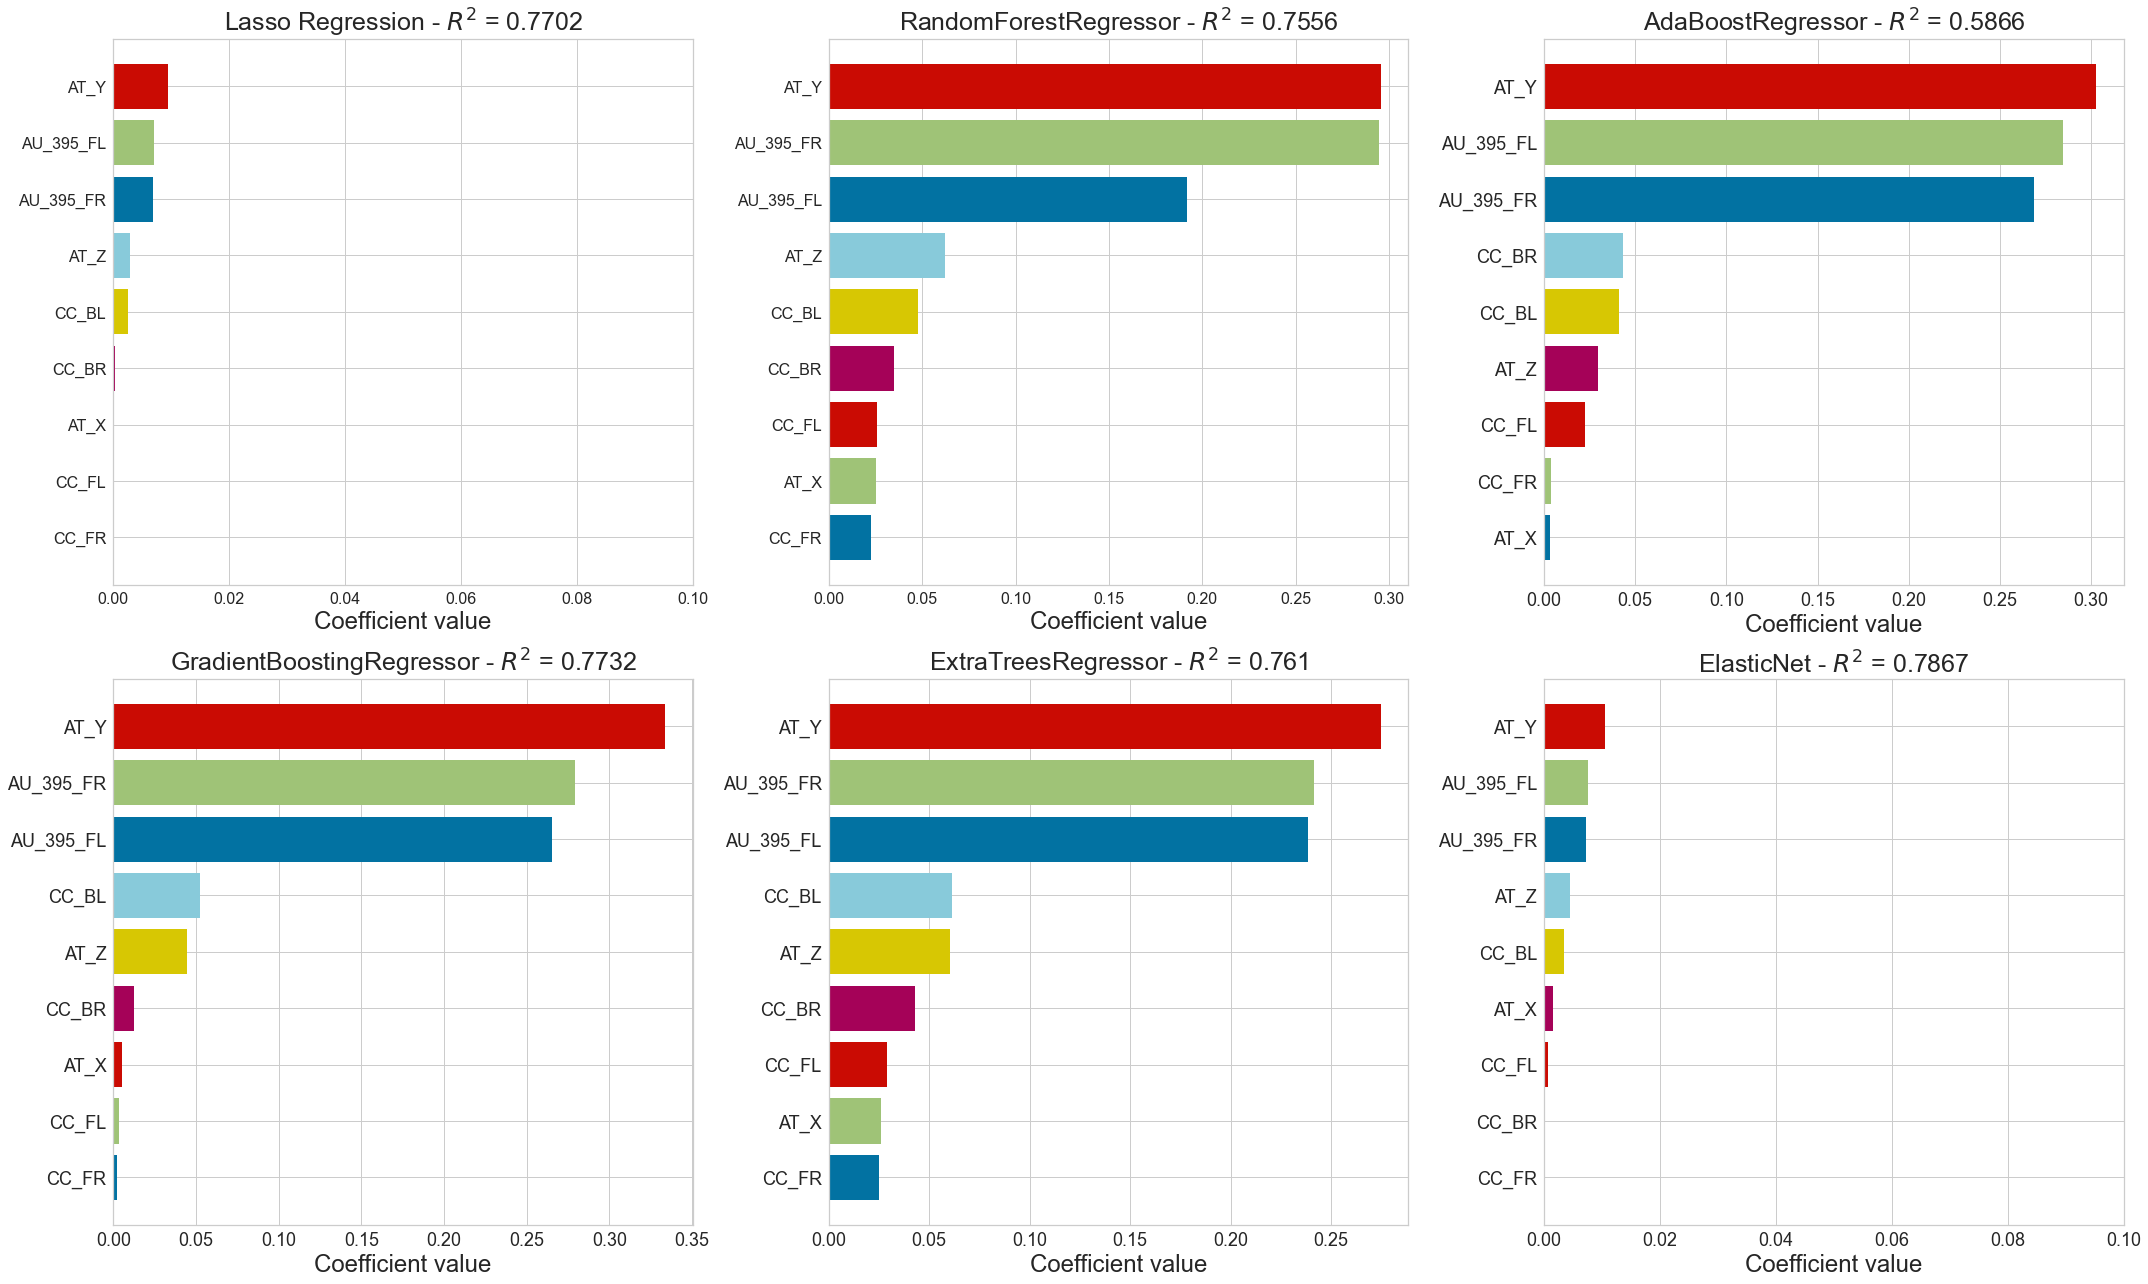

In [172]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [ ]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [188]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=100,high=500,step=10)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=8, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=8, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-01 10:48:00,950] A new study created in memory with name: no-name-6ace23d6-4fa8-466a-84fd-516c48df5435


In [189]:
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

C:\Users\DELL\AppData\Local\Temp\ipykernel_15680\1790555320.py:24: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2022-12-01 10:48:13,816] Trial 0 finished with value: 0.331288313225656 and parameters: {'n_estimators': 380, 'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 3, 'max_features': 2}. Best is trial 0 with value: 0.331288313225656.
C:\Users\DELL\AppData\Local\Temp\ipykernel_15680\1790555320.py:24: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[I 2022-12-01 10:48:35,051] Trial 1 finished with value: 0.760363822029539 and parameters: {'n_estimators': 130, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 8}. Best is trial 1 with value: 0.760363822029539.
C:\Users\DELL\AppData\Local\Temp\ipykernel_15680\1790555320.py:24

Accuracy: 0.762395015376633
Best hyperparameters: {'n_estimators': 460, 'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'max_features': 7}


In [184]:
joblib.dump(study, "study_RandomForest.pkl")

['study_RandomForest.pkl']

In [190]:
study.best_trial

FrozenTrial(number=23, values=[0.762395015376633], datetime_start=datetime.datetime(2022, 12, 1, 11, 1, 4, 933478), datetime_complete=datetime.datetime(2022, 12, 1, 11, 1, 52, 991904), params={'n_estimators': 460, 'max_depth': 42, 'min_samples_leaf': 6, 'min_samples_split': 4, 'max_features': 7}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=10), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=8, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=8, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=23, state=TrialState.COMPLETE, value=None)

In [191]:
optuna.visualization.plot_optimization_history(study)

In [192]:
optuna.visualization.plot_slice(study)

### ElasticNet

In [194]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=10, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_en = optuna.create_study(direction='maximize')

[I 2022-12-01 11:37:49,364] A new study created in memory with name: no-name-663adcc6-a3dc-4be2-9e36-b7a69ef0bb99


In [195]:
study_en.optimize(objective, n_trials=500)

trial_en = study_en.best_trial

print('Accuracy: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

[I 2022-12-01 11:37:52,378] Trial 0 finished with value: -0.019455411179136295 and parameters: {'alpha': 9.0907, 'l1_ratio': 0.71, 'selection': 'cyclic'}. Best is trial 0 with value: -0.019455411179136295.
[I 2022-12-01 11:37:52,412] Trial 1 finished with value: -0.019455411179136295 and parameters: {'alpha': 7.3548, 'l1_ratio': 0.12, 'selection': 'random'}. Best is trial 0 with value: -0.019455411179136295.
[I 2022-12-01 11:37:52,449] Trial 2 finished with value: -0.019455411179136295 and parameters: {'alpha': 3.5658000000000003, 'l1_ratio': 0.81, 'selection': 'cyclic'}. Best is trial 0 with value: -0.019455411179136295.
[I 2022-12-01 11:37:52,482] Trial 3 finished with value: -0.019455411179136295 and parameters: {'alpha': 9.444700000000001, 'l1_ratio': 0.48, 'selection': 'random'}. Best is trial 0 with value: -0.019455411179136295.
[I 2022-12-01 11:37:52,516] Trial 4 finished with value: -0.019455411179136295 and parameters: {'alpha': 9.4846, 'l1_ratio': 0.16, 'selection': 'cyclic'}

Accuracy: 0.7867550731281804
Best hyperparameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.17, 'selection': 'random'}


In [196]:
joblib.dump(study_en, "study_ElasticNet.pkl")

['study_ElasticNet.pkl']

In [197]:
study_en.best_trial

FrozenTrial(number=135, values=[0.7867550731281804], datetime_start=datetime.datetime(2022, 12, 1, 11, 38, 11, 706633), datetime_complete=datetime.datetime(2022, 12, 1, 11, 38, 11, 802375), params={'alpha': 0.0014000000000000002, 'l1_ratio': 0.17, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=10.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=135, state=TrialState.COMPLETE, value=None)

In [198]:
optuna.visualization.plot_optimization_history(study_en)

In [199]:
optuna.visualization.plot_slice(study_en)

### AdaBoost

In [200]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=20, high=500, step=1)
    h_learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-01 11:44:09,533] A new study created in memory with name: no-name-667454e3-c33f-4161-9b6e-346fe4370639


In [201]:
study_ab.optimize(objective, n_trials=100)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-12-01 11:44:31,434] Trial 0 finished with value: 0.5815502464022313 and parameters: {'n_estimators': 154, 'learning_rate': 0.6267869575987981, 'loss': 'linear'}. Best is trial 0 with value: 0.5815502464022313.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-12-01 11:44:51,280] Trial 1 finished with value: 0.5351758218678874 and parameters: {'n_estimators': 107, 'learning_rate': 0.07366418304311065, 'loss': 'square'}. Best is trial 0 with value: 0.5815502464022313.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklea

Accuracy: 0.6204645996938037
Best hyperparameters: {'n_estimators': 437, 'learning_rate': 0.9390677509218748, 'loss': 'exponential'}


In [202]:
joblib.dump(study_ab, "study_AdaBost.pkl")

['study_AdaBost.pkl']

In [203]:
optuna.visualization.plot_optimization_history(study_ab)

In [204]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [205]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=20),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-01 12:51:08,665] A new study created in memory with name: no-name-df7a3ab7-aac3-4a03-b2b8-2698142dd02b


In [206]:
study_xgbr.optimize(objective, n_trials=50)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].

[I 2022-12-01 12:52:45,214] Trial 0 finished with value: 0.7524982585878205 and parameters: {'lambda': 0.20553411372228192, 'alpha': 0.0037230698890566623, 'colsample_bytree': 0.3, 'subsample': 0.4, 'n_estimators': 975, 'max_depth': 20, 'min_split_loss': 0.007587951282977254, 'min_child_weight': 7.6, 'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.7}. Best is trial 0 with value: 0.7524982585878205.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].

[I 2022-12-01 12:53:24,081] Trial 1 finished with value: 0.5058514702146745 and parameters: {'lambda': 0.008371

Accuracy: 0.7723442768958919
Best hyperparameters: {'lambda': 1.9322208518627544, 'alpha': 0.0420543107376445, 'colsample_bytree': 0.3, 'subsample': 0.30000000000000004, 'n_estimators': 3100, 'max_depth': 20, 'min_split_loss': 0.0020922536398972937, 'min_child_weight': 7.6, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.4}


In [208]:
joblib.dump(study_xgbr, "study_XGBoost.pkl")

['study_XGBoost.pkl']

In [209]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [210]:
optuna.visualization.plot_slice(study_xgbr)

In [212]:
study = joblib.load("study_XGBoost.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ",study.best_params)

Best trial until now:
 Value:  0.7723442768958919
 Params:  {'lambda': 1.9322208518627544, 'alpha': 0.0420543107376445, 'colsample_bytree': 0.3, 'subsample': 0.30000000000000004, 'n_estimators': 3100, 'max_depth': 20, 'min_split_loss': 0.0020922536398972937, 'min_child_weight': 7.6, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.4}


In [215]:
import xgboost as xgb
mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)

RMSE:  0.00010724031829497585
R2:  0.7723442768958919


In [216]:
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)
predito

In [219]:
real.shape


(18433, 1)

(18433,)

In [217]:
residuals = real - predito

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

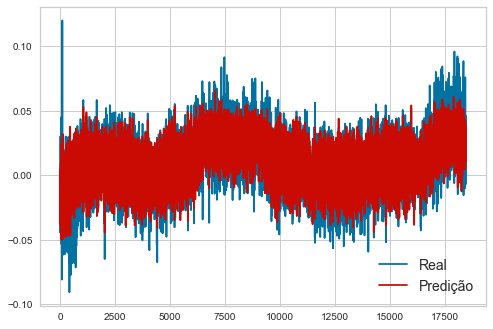

In [214]:
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.legend(fontsize=14)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

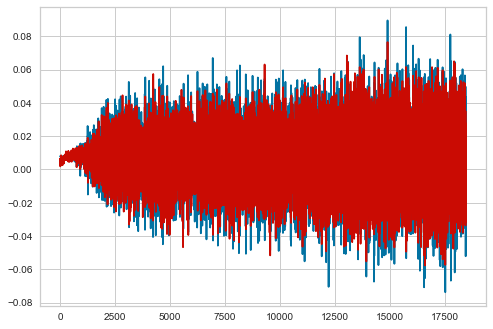

In [142]:
plt.plot(real,'b')
plt.plot(predito,'r')
#RMSE:  7.060226379602361e-05
#R2:  0.777618309633994

In [178]:
predicted = pd.DataFrame(p, columns = ['L/V_FR'])
predicted.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real_xgboost.csv', index=False)

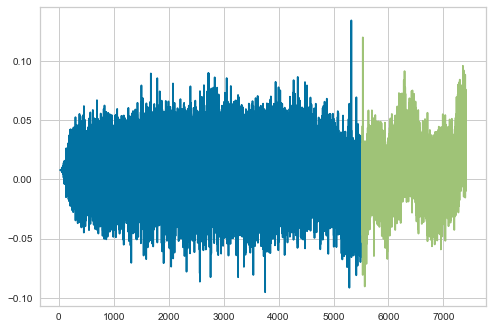

In [69]:
plt.plot(y_train)
plt.plot(y_test)

In [124]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.7,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [125]:
X, y = df_nadal[['CC_FR','CC_FL','CC_BR', 'CC_BL','AT_Y',
'AU_395_FR','AU_395_FL','AT_Z','AT_X']], df_nadal[['L/V_FR']]
X_final_test,X_final_train,y2_test,y2_train = create_scaled_dataset(X,y)

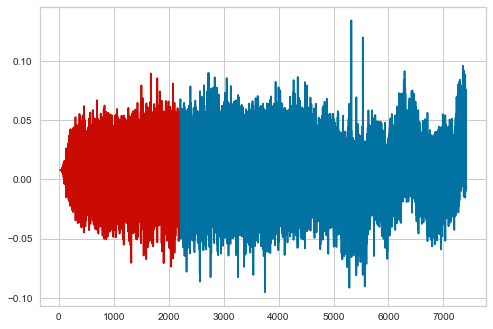

In [126]:
plt.plot(y2_train,'b')
plt.plot(y2_test,'r')

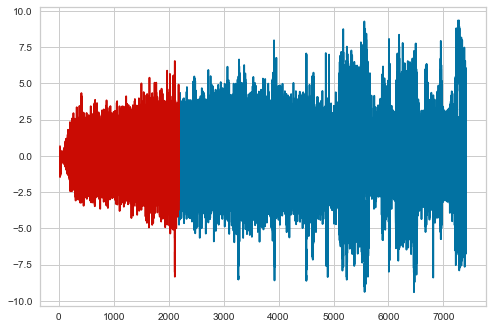

In [127]:
plt.plot(X_final_train,'b')
plt.plot(X_final_test,'r')

# Learning Curve

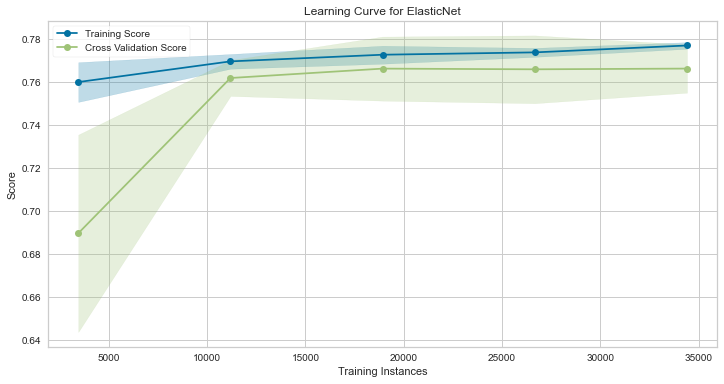

<AxesSubplot:title={'center':'Learning Curve for ElasticNet'}, xlabel='Training Instances', ylabel='Score'>

In [161]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
model = ElasticNet(alpha = 0.0014000000000000002, l1_ratio = 0.3, selection = 'random')
visualizer = LearningCurve(model, scoring='r2')

visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

ValueError: Unable to coerce to Series, length must be 1: given 43010

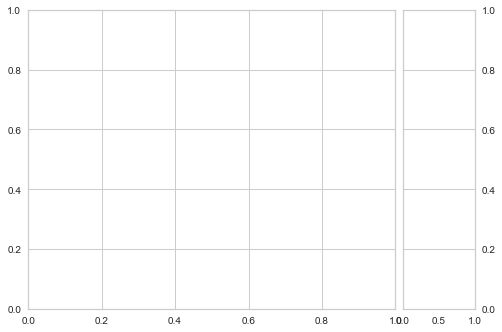

In [162]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()       

(43010, 9)

In [ ]:
CB = CatBoostRegressor()

# Initialize CatBoostRegressor
#model = CatBoostRegressor(iterations=2,
#                          learning_rate=1,
#                          depth=2)
# Fit model
#model.fit(train_data, train_labels)
# Get predictions
#preds = model.predict(eval_data)